<h1 style="text-align: center;">Pitch Classification Model</h1>

## Necessary Libraries

In [294]:
import pandas as pd
import numpy as np
import joblib

## ML libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from skopt import BayesSearchCV
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score

## visalization libraries
import seaborn as sns
import plotly.express as px

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Patch

pd.options.display.max_columns = None

## Data Cleaning

In [295]:
def transform_tagged_pitches(pitch_type: str):
    """
    Maps the pitch of TaggedPitchType to be on the same wavelength as AutoPitchType
    """
    mapping = {'FourSeamFastBall': 'Four-Seam', 
               'Fastball': 'Four-Seam', 
               'TwoSeamFastBall': 'Sinker', 
               'ChangeUp': 'Changeup', 
               'Sweeper': 'Slider'
               }
    return mapping.get(pitch_type, pitch_type)

In [297]:
df = pd.read_csv('../../Files/merged_trackman_games.csv').copy()
df = df.sample(len(df), random_state=42).reset_index(drop=True).copy()
# df = df[['Pitcher', 'PitcherThrows', 'PitcherTeam', 'TaggedPitchType', 'AutoPitchType', 
#          'RelSpeed', 'VertRelAngle', 'HorzRelAngle', 'SpinRate', 'SpinAxis', 'RelHeight', 'RelSide',
#          'Extension', 'InducedVertBreak', 'HorzBreak', 'VertApprAngle', 'HorzApprAngle']].copy()

# ## gets rid of the pitches without any data for it
# df = df[~df['RelSpeed'].isna()].reset_index(drop=True).copy()

# ## makes the pitch names be consistent
# df['AutoPitchType'] = df.apply(lambda x: x['TaggedPitchType'] if x['AutoPitchType'] == 'Other' else x['AutoPitchType'], axis=1)
# df['TaggedPitchType'] = df.apply(lambda x: x['AutoPitchType'] if (x['TaggedPitchType']=='Other' or x['TaggedPitchType']=='Knuckleball') else x['TaggedPitchType'], axis=1)
# df['TaggedPitchType'] = df['TaggedPitchType'].apply(transform_tagged_pitches)
# df['AutoPitchType'] = df['AutoPitchType'].apply(transform_tagged_pitches)

# ## imputes the null values of Extension
# df['Extension'] = df['Extension'].fillna(df.groupby(['Pitcher', 'PitcherThrows', 'PitcherTeam'])['Extension'].transform('mean'))

# df['PitcherThrows'] = df['PitcherThrows'].apply(lambda x: x=='Right').astype(int)
df

/var/folders/6l/fh4ck8px62x4x7vp3j9kjr6h0000gn/T/ipykernel_2488/3150772856.py:1: DtypeWarning: Columns (91,92) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../Files/merged_trackman_games.csv').copy()


,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,HomeTeamForeignID,AwayTeamForeignID,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence
0,281,2025-02-23,15:29:29.23,2,4,"Tompkins, Mason",1.009425e+07,Right,WIN_EAG,"Whooley, Michael",1.000239e+09,Right,VIL_WIL,Undefined,8,Top,1,1,2,Slider,Slider,InPlay,Undefined,GroundBall,Single,0,0,79.34717,-0.457628,-0.724767,2334.673874,86.751405,9:00,5.52074,1.08509,5.30115,-45.21502,0.78831,-14.78052,1.32317,-0.82704,72.11105,-8.703215,-3.353150,0.488164,76.71035,7.333415,-36.608194,2413.389270,NaN,NaN,NaN,111.25452,100.87080,-39.730617,1.089883,7.21426,0.97382,-1.00794,50.0,5.44634,2.04686,-115.04214,-2.47296,9.51096,24.58030,-30.89021,WIN_EAG,VIL_WIL,WinthropUniversity,D1,BSOU,20250223-WinthropUniversity-1,e2253b50-f224-11ef-a858-51f09e38fb92,77.21260,4.99262,NaN,7.23611,NaN,NaN,NaN,2.44399,1.51891,0.80675,db11ed56-079f-496a-aba1-680743e22d4e,2025-02-23,20:29:29.23,2025-02-23T15:29:29.2320000-05:00,2025-02-23T20:29:29.2320000Z,GroundBall,v3,471494,471478,NaN,"Howell, Dylan",1.000255e+09,Right,WIN_EAG,51092d59-65bc-4e76-80cd-5b7ed2915a44,55.19613,-116.14705,12.29015,5.52630,-1.08441,-15.44511,-1.09034,1.61933,4.75548,106.797817,2.44399,89.57531,-14.66737,2.76281,-0.55676,0.09385,-0.01598,0.00273,-0.00027,1.51891,14.36091,-15.17844,0.71783,-0.06114,0.00953,0.00100,-0.00019,-0.00001,0.80675,-66.54437,0.09054,0.57505,-0.22448,0.05905,-0.01354,0.00242,-0.00026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,High,High,NaN,NaN,NaN
1,118,2025-02-26,19:06:57.82,3,5,"Guardiancic, Jake",8.220220e+05,Right,CAL_BEA,"Leroy, Tyler",1.000066e+09,Right,CSU_BAK,Undefined,4,Top,0,2,2,Slider,Curveball,FoulBallNotFieldable,Undefined,Undefined,Undefined,0,0,76.13888,2.705362,0.769766,2344.003236,80.077742,8:45,4.78080,2.00441,6.07221,-51.19904,-1.98512,-22.34970,3.01971,0.85428,67.98925,-6.835289,-3.255055,0.504912,74.07617,

## EDA

In [164]:
def pitch_type_group(pitch_type: str):
    """
    Maps out the pitch type and outputs its pitch group (e.g., 4S are fastballs, SL are breaking balls, etc.)
    """
    pitch_groups = {'Fastball': ['Sinker', 'Four-Seam', 'Cutter'],
                    'Breakingball': ['Slider', 'Curveball'],
                    'Offspeed': ['Changeup', 'Splitter']
                    }
    for k, v in pitch_groups.items():
        if pitch_type in v:
            return k
    return np.nan

In [165]:
## finds the pitch groups from each classification system
df['TaggedGroup'] = df['TaggedPitchType'].apply(pitch_type_group)
df['AutoGroup'] = df['AutoPitchType'].apply(pitch_type_group)

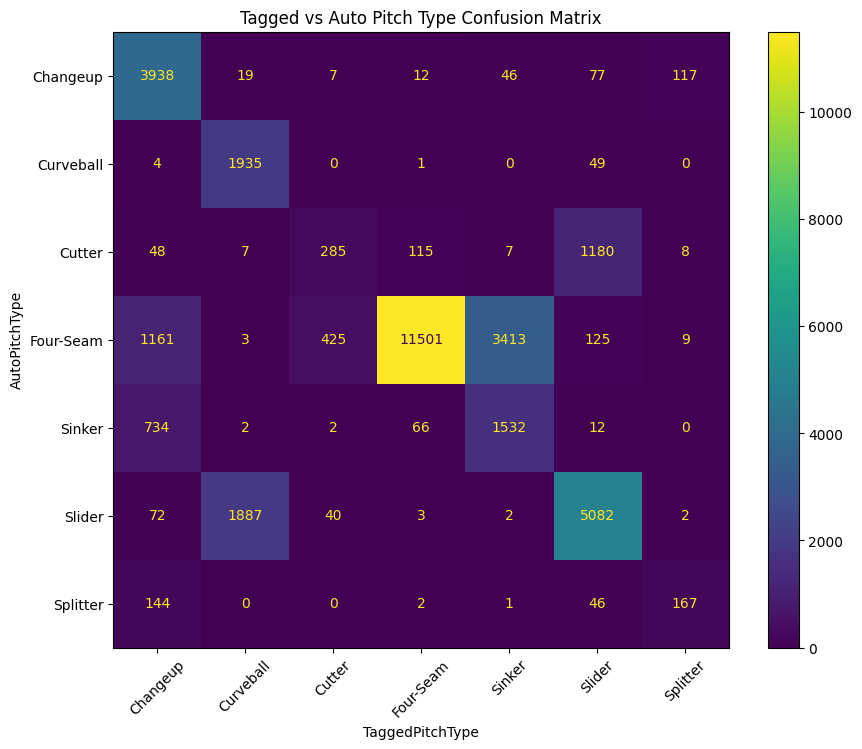

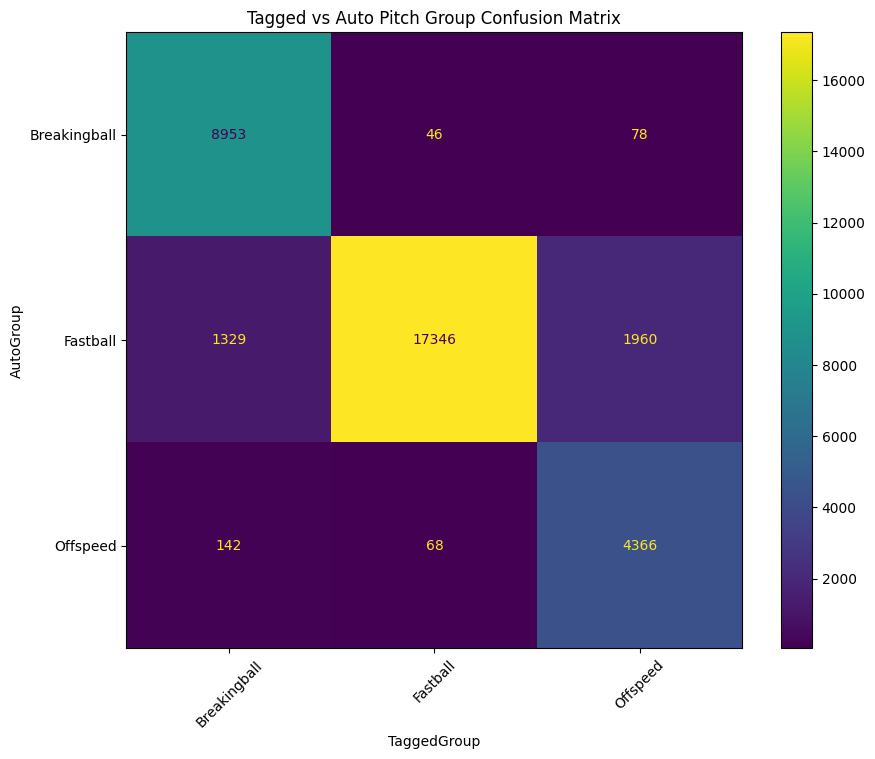

In [166]:
## individual pitches
labels = sorted(set(df["TaggedPitchType"].unique()) | set(df["AutoPitchType"].unique()))
cm = confusion_matrix(df["TaggedPitchType"], df["AutoPitchType"], labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.viridis)
ax.set_xlabel("TaggedPitchType")
ax.set_ylabel("AutoPitchType")
plt.title("Tagged vs Auto Pitch Type Confusion Matrix")
plt.show()

## pitch groups
group_labels = sorted(set(df["TaggedGroup"].unique()) | set(df["AutoGroup"].unique()))
group_cm = confusion_matrix(df["TaggedGroup"], df["AutoGroup"], labels=group_labels)
group_disp = ConfusionMatrixDisplay(confusion_matrix=group_cm, display_labels=group_labels)
fig, ax = plt.subplots(figsize=(10, 8))
group_disp.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.viridis)
ax.set_xlabel("TaggedGroup")
ax.set_ylabel("AutoGroup")
plt.title("Tagged vs Auto Pitch Group Confusion Matrix")
plt.show()

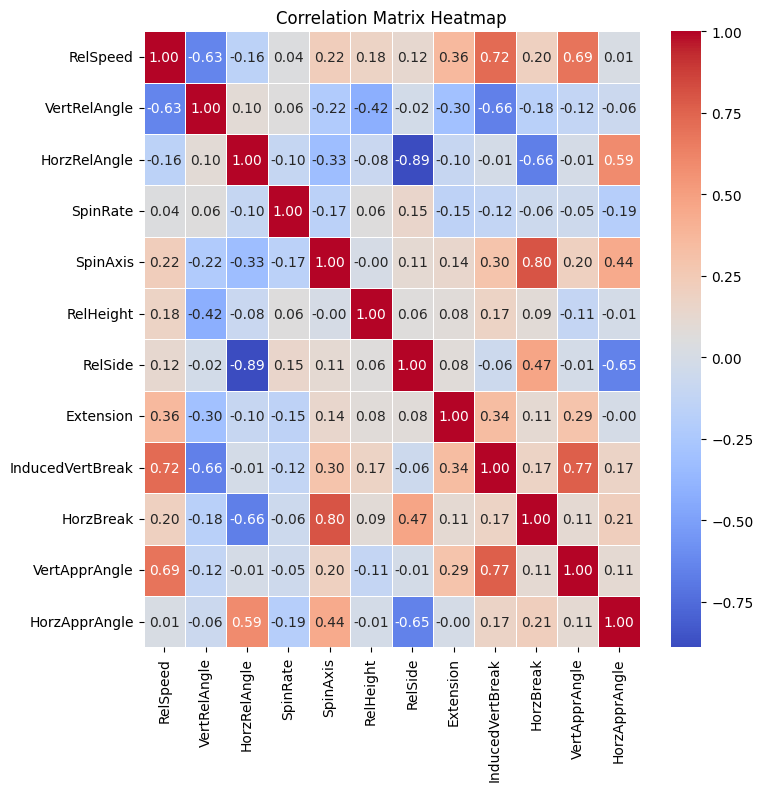

In [167]:
plt.figure(figsize=(8, 8)) 
correlation_matrix = df.iloc[:, 5:-2].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [168]:
df = df[['Pitcher', 'PitcherThrows', 'PitcherTeam', 'TaggedPitchType', 'AutoPitchType', 'TaggedGroup', 'AutoGroup',
         'RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].copy()
training_data = df[df['TaggedPitchType'] == df['AutoPitchType']].reset_index(drop=True).copy()
training_data['is_fastball'] = (training_data['TaggedGroup'] == 'Fastball').astype(int)
training_data['is_breakingball'] = (training_data['TaggedGroup'] == 'Breakingball').astype(int)
training_data['is_offspeed'] = (training_data['TaggedGroup'] == 'Offspeed').astype(int)
training_data

,Pitcher,PitcherThrows,PitcherTeam,TaggedPitchType,AutoPitchType,TaggedGroup,AutoGroup,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,RelHeight,RelSide,is_fastball,is_breakingball,is_offspeed
0,"Frutchey, Ned",1,CAL_AGO,Sinker,Sinker,Fastball,Fastball,89.97363,2072.314793,273.811191,-0.12673,20.82186,4.89641,3.68458,1,0,0
1,"Kleinschmit, Ethan",0,ORE_BEA,Four-Seam,Four-Seam,Fastball,Fastball,89.34788,2320.691428,147.933294,21.32363,-12.51705,6.23134,-1.81031,1,0,0
2,"Schreiber, Sebastian",0,SAN_BRO,Four-Seam,Four-Seam,Fastball,Fastball,89.84874,2209.062805,156.488368,18.43903,-7.53374,5.89446,-2.35336,1,0,0
3,"O'Brien, Liam",1,HAW_WAR,Sinker,Sinker,Fastball,Fastball,91.93440,2149.284013,250.575677,9.71457,23.62769,6.24725,1.34897,1,0,0
4,"Magdaleno, Isaiah",1,HAW_WAR,Four-Seam,Four-Seam,Fastball,Fastball,90.21070,2102.584566,196.134288,20.11127,5.49780,6.39547,1.76411,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24435,"Villar, Jake",0,CSD_TRI,Slider,Slider,Breakingball,Breakingball,77.85753,2221.303829,301.705492,1.02445,1.76811,5.60976,-2.54222,0,1,0
24436,"Volmerding, Joshua",0,CAL_MUS,Four-Seam,Four-Seam,Fastball,Fastball,89.66482,2242.298434,143.353185,16.33678,-11.25087,6.40509,-1.42076,1,0,0
24437,"Martin, Max",1,CAL_ANT,Slider,Slider,Breakingball,Breakingball,80.87106,2134.440569,94.265240,2.29536,-12.85969,5.45329,2.17339,0,1,0
24438,"Faulks, Ryan",1,CAL_FUL,Four-Seam,Four-Seam,Fastball,Fastball,89.26862,2339.317383,201.757982,16.62528,6.16111,5.32333,2.25097,1,0,0


In [169]:
## 4-seam fastballs
training_data[training_data['TaggedPitchType']=='Four-Seam'][['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].describe()

,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,RelHeight,RelSide
count,11501.00000,11501.000000,11501.000000,11501.000000,11501.000000,11501.000000,11501.000000
mean,90.11426,2243.454486,190.996287,19.517354,3.823408,5.955405,0.655644
std,2.82541,153.290287,25.675386,3.131458,9.049555,0.392214,1.458252
min,81.77749,1674.067602,105.403592,6.271700,-24.537850,4.237010,-3.593960
25%,88.09250,2142.976621,168.840805,17.440880,-3.649840,5.687130,-0.611140
50%,89.85395,2245.019800,200.358978,19.630760,6.866740,5.946090,1.137850
75%,91.76657,2348.889081,210.449990,21.683040,10.549810,6.220280,1.698120
max,100.26293,2746.632478,240.743975,37.688640,22.650130,7.113890,3.601450


In [170]:
## Sinkers
training_data[training_data['TaggedPitchType']=='Sinker'][['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].describe()

,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,RelHeight,RelSide
count,1532.000000,1532.000000,1532.000000,1532.000000,1532.000000,1532.000000,1532.000000
mean,90.047500,2127.609074,195.980098,9.161044,4.379211,5.430310,0.539573
std,1.862730,164.233670,66.203947,4.233752,18.143281,0.505662,1.996162
min,84.729260,1601.265496,63.876383,-9.042410,-28.516470,3.460760,-3.799850
25%,88.821465,2025.675573,119.629594,6.979885,-17.351743,5.114867,-1.468385
50%,89.878725,2139.826033,236.747581,9.830675,16.118475,5.512005,1.626640
75%,91.218725,2241.776280,248.494979,12.141900,19.258267,5.770130,2.131692
max,96.006150,2622.941603,302.610051,20.121700,27.920720,6.712810,3.794380


In [171]:
## cutters
training_data[training_data['TaggedPitchType']=='Cutter'][['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].describe()

,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,RelHeight,RelSide
count,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000
mean,87.130311,2330.577227,186.207766,11.015983,1.070754,6.038459,-0.460323
std,2.279983,143.804231,19.079249,2.339727,3.277188,0.428417,1.821440
min,80.703740,1955.162637,136.812467,5.023110,-7.516930,4.717840,-2.446840
25%,85.699890,2250.492615,172.973044,9.267370,-1.286970,5.764860,-2.096160
50%,87.409480,2328.451133,184.755861,11.030480,0.805550,5.938610,-1.582930
75%,88.828190,2404.678961,198.420069,12.508550,3.025510,6.362240,1.606450
max,92.463710,2735.148304,243.793661,18.303550,10.157370,6.930320,3.433090


In [172]:
## changeups
training_data[training_data['TaggedPitchType']=='Changeup'][['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].describe()

,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,RelHeight,RelSide
count,3938.000000,3938.000000,3938.000000,3938.000000,3938.000000,3938.000000,3938.000000
mean,80.533445,1814.584164,191.085269,7.700506,3.141654,5.679719,0.295309
std,3.309786,340.974958,70.908228,5.178183,16.426211,0.438062,1.894129
min,66.096850,946.173607,30.674580,-8.981190,-27.353720,3.562440,-3.764240
25%,77.758207,1546.149711,114.674644,4.016185,-14.474127,5.453947,-1.674225
50%,80.451595,1793.700899,231.488254,8.027055,12.453350,5.643960,1.269855
75%,83.257480,2069.538497,251.195745,11.337900,17.615810,5.905040,1.859615
max,90.409420,2745.807227,334.989084,25.227420,27.750680,6.963470,3.701120


In [173]:
## splitters
training_data[training_data['TaggedPitchType']=='Splitter'][['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].describe()

,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,RelHeight,RelSide
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,83.865781,976.387420,257.112458,3.297621,10.852042,5.699372,1.835090
std,2.746816,110.255347,37.623133,5.827693,4.839619,0.375347,0.626019
min,77.224200,714.194745,4.455092,-14.311030,-15.456820,4.591680,-1.489640
25%,81.636290,891.346947,241.479846,-1.179550,8.425260,5.227955,1.279940
50%,84.667960,985.210733,255.535308,3.955710,11.516460,5.830540,2.054600
75%,86.143030,1051.121726,283.084999,7.451560,14.000480,5.964225,2.279470
max,88.366480,1191.502900,324.893221,17.454220,19.945330,6.358740,2.951720


In [174]:
## Curveballs
training_data[training_data['TaggedPitchType']=='Curveball'][['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].describe()

,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,RelHeight,RelSide
count,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000
mean,75.885621,2428.130091,89.824534,-12.223226,-6.568524,5.975025,0.891017
std,4.160359,274.823702,114.439478,4.967982,9.047884,0.386601,1.246558
min,61.910670,1630.268348,0.549606,-26.981160,-26.031230,4.574440,-3.029860
25%,73.728835,2233.179114,26.852430,-15.760775,-13.042290,5.708465,0.436130
50%,76.180270,2420.490049,40.525266,-11.911460,-8.609810,5.996070,1.111660
75%,78.704625,2637.484771,58.463993,-8.493805,-2.877835,6.291850,1.714650
max,88.037200,3343.169836,359.793560,6.821340,24.577100,6.943380,3.497590


In [175]:
## Sliders
training_data[training_data['TaggedPitchType']=='Slider'][['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].describe()

,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,RelHeight,RelSide
count,5082.000000,5082.000000,5082.000000,5082.000000,5082.000000,5082.000000,5082.000000
mean,81.170076,2400.048750,151.477877,2.755895,-2.591087,5.641719,0.755455
std,2.839209,231.804096,79.859448,3.942226,9.363848,0.516854,1.728613
min,71.957110,1044.017758,0.540955,-9.778080,-27.041350,2.938360,-3.996870
25%,79.157225,2253.335082,86.809209,-0.080013,-8.324340,5.410012,-0.817790
50%,81.070585,2410.059516,122.683039,2.719750,-3.761535,5.683390,1.404550
75%,83.106545,2555.532868,227.852256,5.457033,3.676025,5.946105,1.989853
max,92.627390,3547.347564,359.596018,19.555520,24.718560,6.939000,4.916360


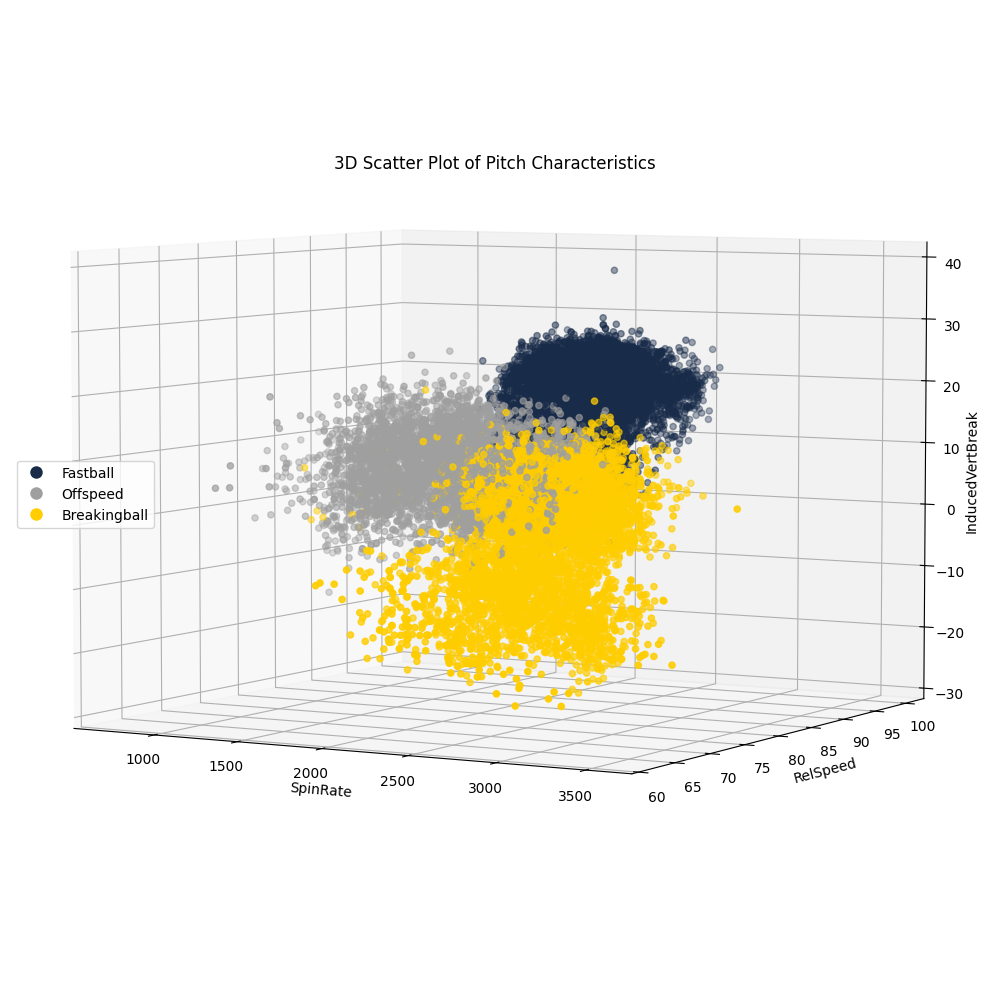

In [177]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

colors = training_data['AutoGroup'].map({'Breakingball': '#FFCD00', 'Fastball': '#182B49', 'Offspeed': '#9f9f9f'})

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Fastball', markerfacecolor='#182B49', markersize=10), 
                   Line2D([0], [0], marker='o', color='w', label='Offspeed', markerfacecolor='#9f9f9f', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Breakingball', markerfacecolor='#FFCD00', markersize=10),
                   ]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(training_data['SpinRate'], training_data['RelSpeed'], training_data['InducedVertBreak'], c=colors, marker='o')
ax.set_xlabel('SpinRate')
ax.set_ylabel('RelSpeed')
ax.set_zlabel('InducedVertBreak', labelpad=0)
ax.set_title('3D Scatter Plot of Pitch Characteristics', y=0.9)
ax.view_init(elev=5, azim=300)
ax.legend(handles=legend_elements, loc='center left')
plt.tight_layout()
plt.show()

## Pitch Group Model

Setting up the training set

In [286]:
group_training_data = training_data.copy()
group_training_data['type_cat_code'] = group_training_data['TaggedPitchType'].astype('category').cat.codes
group_categories = group_training_data['TaggedPitchType'].astype('category').cat.codes

group_X = (group_training_data
           .groupby('type_cat_code')[['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']]
           .transform(lambda x: (x-x.mean()) / x.std())
           )
group_X.loc[:, 'PitcherThrows'] = group_training_data['PitcherThrows']
group_X = group_X.values
group_y = group_training_data['type_cat_code'].values

The model itself: using an xgboost classifier model with bayesian optimization hypertuning

In [289]:
xgb = XGBClassifier(objective="multi:softprob", num_class=7, eval_metric="mlogloss", tree_method="hist", random_state=42)

param_grid = {"n_estimators": (100, 1000), ## num of trees in the model
              "learning_rate": (0.01, 0.3, "log-uniform"), ## the rate at which the model makes changes to the weights
              "max_depth": (3, 7), ## how deep the trees can be
              "min_child_weight": (0.1, 10.0, "log-uniform"), ## min num of obs can be present in each node of the tree
              "subsample": (0.6, 1.0), ## num of obs used to build each tree
              "colsample_bytree": (0.6, 1.0), ## num of features used to build each tree
              "reg_alpha": (1e-3, 10.0, "log-uniform"), ## controls the strength of regularization (l1)
              "reg_lambda": (1e-3, 10.0, "log-uniform"), ## controls the strength of regularization (l2)
              "gamma": (0.0, 5.0), ## min loss reduction required to make a split
              }

## 3-fold stratified cv with bayesian optimization hypertuning to find the best xgboost model
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
opt = BayesSearchCV(estimator=xgb, search_spaces=param_grid, n_iter=50, cv=cv, n_jobs=-1, scoring="neg_log_loss", verbose=1, random_state=42)
opt.fit(group_X, group_y)

## final training with validation split: checking generalization
X_train, X_val, y_train, y_val = train_test_split(group_X, group_y, test_size=0.1, stratify=group_y, random_state=42)
best_xgb = opt.best_estimator_
best_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.08467607452822379, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=0.1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None, num_class=7,
              num_parallel_tree=None, ...)

Evaluating the model

Log loss: 0.16234995340195857
Accuracy: 0.9398527004909983


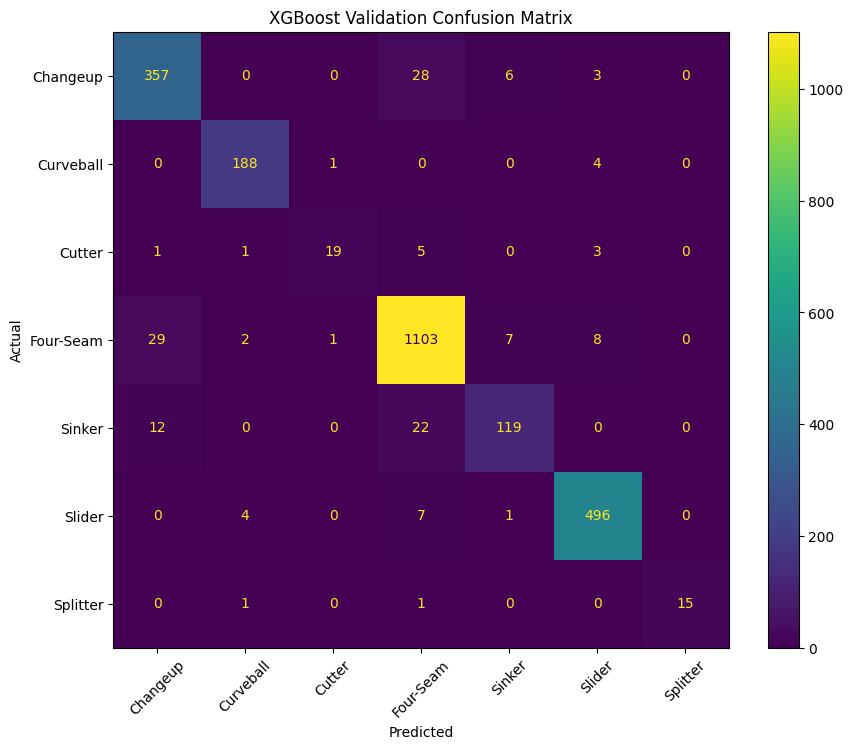

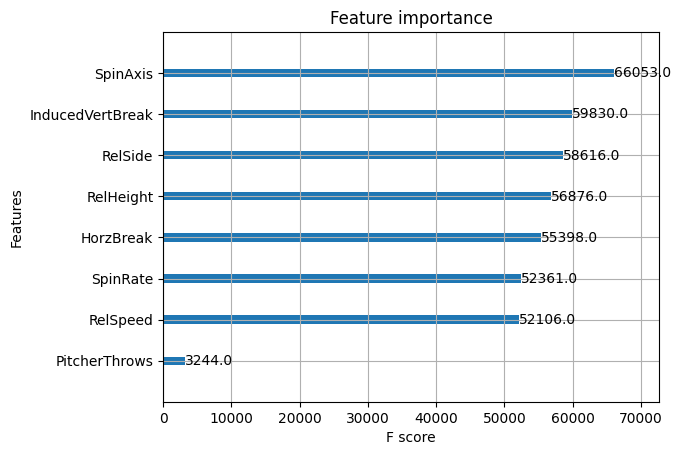

In [290]:
y_train_prob = best_xgb.predict_proba(X_train)  
y_train_pred = best_xgb.predict(X_train)  

y_val_prob = best_xgb.predict_proba(X_val)
y_val_pred = best_xgb.predict(X_val)

## evaluation metrics
print("Log loss:", log_loss(y_val, y_val_prob))
print("Accuracy:", accuracy_score(y_val, y_val_pred))

## confusion matrix for the model's results
cat_dtype = group_training_data['TaggedPitchType'].astype('category')
class_names = cat_dtype.cat.categories.tolist()
xgb_cm = confusion_matrix(y_val, y_val_pred)
xgb_disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 8))
xgb_disp.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.viridis)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.title("XGBoost Validation Confusion Matrix")
plt.show()

## displays the importance of each feature used (# is the # of times each feature is used in splits across the trees)
feature_names = ["RelSpeed", "SpinRate", "SpinAxis", "InducedVertBreak", 'HorzBreak', 'RelHeight', 'RelSide', 'PitcherThrows']
best_xgb.get_booster().feature_names = feature_names
plot_importance(best_xgb, max_num_features=10)
plt.show()

probs_df = pd.DataFrame(y_val_prob, columns=class_names)
probs_df["TrueLabel"] = [class_names[i] for i in y_val]
probs_df["PredLabel"] = [class_names[i] for i in y_val_pred]

In [291]:
joblib.dump(best_xgb, "best_xgb_model.pkl")
best_xgb = joblib.load("best_xgb_model.pkl")
best_xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.08467607452822379, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=0.1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None, num_class=7,
              num_parallel_tree=None, ...)

In [292]:
display(group_training_data.groupby('type_cat_code')[['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].mean().reset_index())
display(group_training_data.groupby('type_cat_code')[['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].std().reset_index())

,type_cat_code,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,RelHeight,RelSide
0,0,80.533445,1814.584164,191.085269,7.700506,3.141654,5.679719,0.295309
1,1,75.885621,2428.130091,89.824534,-12.223226,-6.568524,5.975025,0.891017
2,2,87.130311,2330.577227,186.207766,11.015983,1.070754,6.038459,-0.460323
3,3,90.114260,2243.454486,190.996287,19.517354,3.823408,5.955405,0.655644
4,4,90.047500,2127.609074,195.980098,9.161044,4.379211,5.430310,0.539573
5,5,81.170076,2400.048750,151.477877,2.755895,-2.591087,5.641719,0.755455
6,6,83.865781,976.387420,257.112458,3.297621,10.852042,5.699372,1.835090


,type_cat_code,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,RelHeight,RelSide
0,0,3.309786,340.974958,70.908228,5.178183,16.426211,0.438062,1.894129
1,1,4.160359,274.823702,114.439478,4.967982,9.047884,0.386601,1.246558
2,2,2.279983,143.804231,19.079249,2.339727,3.277188,0.428417,1.821440
3,3,2.825410,153.290287,25.675386,3.131458,9.049555,0.392214,1.458252
4,4,1.862730,164.233670,66.203947,4.233752,18.143281,0.505662,1.996162
5,5,2.839209,231.804096,79.859448,3.942226,9.363848,0.516854,1.728613
6,6,2.746816,110.255347,37.623133,5.827693,4.839619,0.375347,0.626019


In [293]:
test_data = df[df['TaggedPitchType'] != df['AutoPitchType']].reset_index(drop=True).copy()
test_data

,Pitcher,PitcherThrows,PitcherTeam,TaggedPitchType,AutoPitchType,TaggedGroup,AutoGroup,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,RelHeight,RelSide
0,"Hasegawa, Sam",0,CSD_TRI,Four-Seam,Cutter,Fastball,Fastball,88.63275,2389.154343,185.102970,8.42355,0.64398,5.86064,-2.20345
1,"MIranda, Evan",1,SAN_AZT,Four-Seam,Changeup,Fastball,Offspeed,88.19658,1770.988616,208.206533,17.59418,8.76552,6.29455,1.99818
2,"Patrick, Tyler",1,FRE_BUL,Slider,Curveball,Breakingball,Breakingball,76.09483,2240.280800,36.597641,-12.00406,-10.31394,5.68271,2.14119
3,"Mejia, Tyler",0,CAL_MAT,Four-Seam,Sinker,Fastball,Fastball,86.05752,2191.128814,132.555124,18.34190,-18.23773,5.98483,-2.69721
4,"Schreiber, Sebastian",0,SAN_BRO,Slider,Curveball,Breakingball,Breakingball,76.93013,1951.210949,306.017153,-2.17110,4.74048,5.47900,-3.20844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9843,"Downs, Chris",0,CAL_MUS,Four-Seam,Changeup,Fastball,Offspeed,85.31261,2036.941035,131.044796,14.06808,-14.79832,6.23455,-2.36553
9844,"Smith, Dylan",1,CAL_FUL,Slider,Curveball,Breakingball,Breakingball,78.45771,2643.262958,51.284416,-4.27028,-6.91741,5.78936,2.10741
9845,"Laine, Avery",1,LOY_LIO,Cutter,Slider,Fastball,Breakingball,80.28349,2258.784650,180.150613,10.17886,0.02287,5.66279,1.46960
9846,"Wright, Andrew",0,CAL_FUL,Four-Seam,Sinker,Fastball,Fastball,91.80732,2011.226302,131.825987,15.19509,-15.74820,5.17966,-0.87079
